# BERT Embeddings with K-Means Clustering

This method involves vectorising the text data into Bidirectional Encoder Representations from Transformers (BERT) embeddings, then clustering the data using K-Means Clustering. Sentiment analysis is conducted on each cluster, where "positive", "neutral" and "negative" sentiment labels are assigned to each data point based on the average sentiment score per cluster.

When it comes to short text clustering, one limitation is that vectorising the text leads to high-dimensional features, making it harder to measure distance between points. Clustering also becomes more computationally expensive. To address this, we have reduced the dimensions of the BERT embeddings using Uniform Manifold Approximation and Projection (UMAP). UMAP is a method used to reduce the number of dimensions in a dataset while maintaining its essential structure.
Reference: Short Text Clustering Algorithms, Application and Challenges: A Survey (2023)

Ahmed, M. H., Tiun, S., Omar, N., & Sani, N. S. (2022). Short Text Clustering Algorithms, Application and Challenges: A Survey. Applied Sciences, 13(1), 342. https://doi.org/10.3390/app13010342


## Read in the data

In [ ]:
# Read in the data
import pandas as pd
file_path = "Tweets.csv"
df = pd.read_csv(file_path, delimiter=None, engine='python')
print(df.head())
print(df.columns)


  airline_sentiment  sentiment_confidence  \
0           neutral                1.0000   
1          positive                0.3486   
2           neutral                0.6837   
3          negative                1.0000   
4          negative                1.0000   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...  
Index(['airline_sentiment', 'sentiment_confidence', 'text'], dtype='object')


In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)



True

## Cleaning the data

To clean the data, we reduced the text to its base form, handled contractions, converted emojis to text and removed special characters. We also removed hyperlinks and airline mentions.

In [ ]:
import contractions  # Import contractions package for contraction expansion
import re
import pandas as pd
import emoji
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import contractions  # Import contractions package for contraction expansion
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Define the list of airlines (case-insensitive)
airline_list = ["VirginAmerica", "united", "SouthwestAir", "JetBlue", "USAirways", "AmericanAir"]

lemmatizer = WordNetLemmatizer()

def clean_text(text):

    # Remove stop words
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words]
    text = " ".join(words)  # Assign it back to update the text

    # Expand contractions using the contractions package
    text = contractions.fix(text)  # Converts contractions like "don't" to "do not", etc.

    # Remove hashtags while keeping the words
    text = re.sub(r'#(\w+)', r'\1', text)  # This removes the "#" symbol but keeps the word following it

    # Regex pattern for airline mentions (case-insensitive)
    airline_pattern = r'@(' + '|'.join(airline_list) + r')\b'
    match = re.search(airline_pattern, text, re.IGNORECASE)

    # Extract airline name if found
    airline = match.group(1) if match else "Unknown"

    # Remove only the airline mention
    text = re.sub(airline_pattern, '', text, flags=re.IGNORECASE).strip()

    # Check if text contains a link
    link_pattern = r'http\S+'  # Matches any URL starting with "http" or "https"
    has_link = 1 if re.search(link_pattern, text) else 0  # 1 if link exists, else 0

    # Remove the link from the text
    text_without_link = re.sub(link_pattern, '', text).lower().strip()

    return airline, has_link, text_without_link

# Apply function and create new columns
df[['airline', 'has_link', 'clean_text']] = df['text'].apply(lambda x: pd.Series(clean_text(x)))
# Display first few rows
df[345:399]

# Convert Emojis to Text
def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Convert 😊 → " 😊 "

# Apply emoji conversion
df['clean_text_emoji'] = df['clean_text'].apply(convert_emojis)

# Display first few rows of the emoji-converted text
df[390:400]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shannonkwok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shannonkwok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shannonkwok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shannonkwok/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,airline_sentiment,sentiment_confidence,text,airline,has_link,clean_text,clean_text_emoji
390,positive,0.6724,@VirginAmerica omg omg😍😍 nonstop Dallas to Aus...,VirginAmerica,0,omg omg😍😍 nonstop dallas to austin on virgin✨😱✈️,omg omg smiling_face_with_heart-eyes smiling_...
391,positive,1.0000,@VirginAmerica Your planes are really pretty. ...,VirginAmerica,0,your plane are really pretty. just thought you...,your plane are really pretty. just thought you...
392,neutral,1.0000,@VirginAmerica when are you flying to hawaii,VirginAmerica,0,when are you flying to hawaii,when are you flying to hawaii
393,negative,0.6801,@VirginAmerica I'm pulling my hair out trying ...,VirginAmerica,0,i am pulling my hair out trying to book a flig...,i am pulling my hair out trying to book a flig...
394,positive,1.0000,@VirginAmerica thank you,VirginAmerica,0,thank you,thank you
395,negative,0.6307,@VirginAmerica Can I get some help with a supp...,VirginAmerica,0,can i get some help with a support ticket? it ...,can i get some help with a support ticket? it ...
396,positive,1.0000,@VirginAmerica good to be home #texas #moodlig...,VirginAmerica,1,good to be home texas moodlighting,good to be home texas moodlighting
397,negative,1.0000,@VirginAmerica I cannot even open my laptop in...,VirginAmerica,0,i cannot even open my laptop in seat 4c and i ...,i cannot even open my laptop in seat 4c and i ...
398,negative,1.0000,@VirginAmerica I am in seat 4C and I cannot ev...,VirginAmerica,0,i am in seat 4c and i cannot even open my lapt...,i am in seat 4c and i cannot even open my lapt...
399,neutral,1.0000,.@VirginAmerica If only you guys were starting...,VirginAmerica,0,. if only you guy were starting those flight a...,. if only you guy were starting those flight a...


In [ ]:
#!pip install transformers torch
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, pipeline
from tqdm import tqdm
#!pip install umap
from umap.umap_ import UMAP



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BERT embeddings
In this section, we use the DistilBERT model to transform the text into vectorised embeddings. Feature extraction is handled through BERT embeddings, which extract contextual representations of text. The CLS token is used as it is trained to capture a holistic representation of the input, making it effective for classification tasks. As BERT outputs embeddings with dimensions, UMAP is then used to reduce dimensionality while preserving the structure of the data.

In [ ]:
# BERT embeddings

# 1. Load pre-trained DistilBERT model - a model finetuned for sentiment analysis
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 2. Function to get BERT embeddings

def get_bert_embeddings(texts, batch_size=20):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Tokenize the texts
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=280, return_tensors='pt')
        encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

        # Get model output
        with torch.no_grad():
            model_output = model(**encoded_input)

        sentence_embeddings = model_output.last_hidden_state[:, 0, :].cpu().numpy()  # Use CLS token
        all_embeddings.append(sentence_embeddings)

    return np.vstack(all_embeddings)


# 3. Convert tweets to vectorised embeddings
tweets = df['clean_text_emoji'].tolist()
print(f"Processing embeddings for {len(tweets)} tweets...")
embeddings = get_bert_embeddings(tweets)

# 4. Dimensionality reduction using UMAP
umap = UMAP(n_components=15, n_neighbors=15, min_dist=0.1, random_state=100)
reduced_embeddings = umap.fit_transform(embeddings)



Processing embeddings for 14639 tweets...


100%|██████████| 732/732 [01:10<00:00, 10.37it/s]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Elbow Graph
An Elbow Graph of Sum of Squared Errors (SSE) is plotted against the Number of Clusters (K). SSE is the sum of Euclidean Distances between each data point and the cluster centroid they are assigned to. The optimal K is taken to be the graph's inflection point or "elbow". In this case, it seems to be K = 5 or K = 6. After trial and error, K = 6 has produced better results. Hence, K = 6 is selected as the optimal number of clusters.

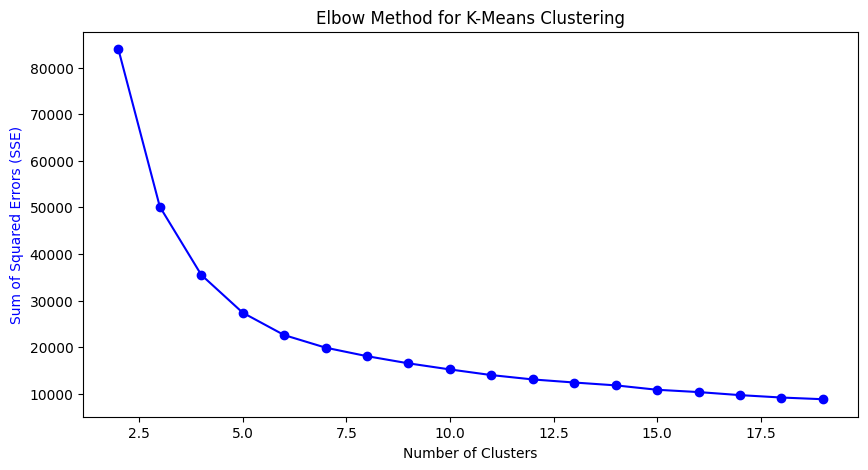

In [ ]:
# Elbow graph to determine optimal K

# Test multiple cluster sizes (K = 2 to K = 20)
sse = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=100, n_init=10)
    labels = kmeans.fit_predict(reduced_embeddings)
    sse.append(kmeans.inertia_)

# Plot Elbow Graph

fig, ax1 = plt.subplots(figsize=(10,5))
K_range = range(2, 20)
ax1.plot(K_range, sse, 'bo-', label="SSE")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Sum of Squared Errors (SSE)", color='b')

plt.title("Elbow Method for K-Means Clustering")
plt.show()


## Training and Testing the Model
This section performs clustering using train and test data. We use the training data to train the model and evaluating its performance in comparison to the test data. As our models are computationally expensive, we decided on a 80-20 split as it has a shorter run time. In this section, we split the embeddings into training and test sets. We performed K-means clustering using the test and training sets separately. Next, we performed sentiment analysis on each of the clusters in both the training and test sets. We compared the difference between the sentiment values in the train and test set for each cluster. Since the absolute differences are found to be very small, we can conclude that the model is unlikely to be overfitted or underfitted.

In [ ]:
# Training and Testing the Model

from sklearn.model_selection import train_test_split

# Split the data with 80-20 train-test ratio
X_train, X_test = train_test_split(reduced_embeddings, test_size=0.2, random_state=100)
tweets_train, tweets_test = train_test_split(tweets, test_size=0.2, random_state=100)

# Apply K-means clustering on the training data
print("Applying K-means clustering...")
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=100)
cluster_labels_train = kmeans.fit_predict(X_train)

# Use the trained model to predict clusters for test data
cluster_labels_test = kmeans.predict(X_test)

# Create separate DataFrames for train and test
df_train = pd.DataFrame({'text': tweets_train, 'cluster': cluster_labels_train})
df_test = pd.DataFrame({'text': tweets_test, 'cluster': cluster_labels_test})

# 6. Use Hugging Face's sentiment pipeline
print("Running sentiment analysis...")
sentiment_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Get sentiment scores for training data
cluster_sentiments = {}

for cluster_id in range(n_clusters):
    # Get sample tweets from this cluster in training data
    cluster_df = df_train[df_train['cluster'] == cluster_id]

    if len(cluster_df) == 0:
        print(f"Warning: Cluster {cluster_id} is empty in training set")
        cluster_sentiments[cluster_id] = 0
        continue

    sample_size = min(100, len(cluster_df))
    sampled_tweets = cluster_df['text'].sample(sample_size, random_state=100).tolist()

    results = sentiment_classifier(sampled_tweets)

    sentiment_scores = []
    for result in results:
        if result['label'] == 'POSITIVE':
            sentiment_scores.append(result['score'])
        else:
            sentiment_scores.append(-result['score'])

    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    cluster_sentiments[cluster_id] = avg_sentiment
    print(f"Training Cluster {cluster_id}: {len(cluster_df)} tweets, avg sentiment = {avg_sentiment:.3f}")

# Evaluate on test set
test_cluster_sentiments = {}

for cluster_id in range(n_clusters):
    cluster_df = df_test[df_test['cluster'] == cluster_id]

    if len(cluster_df) == 0:
        print(f"Warning: Cluster {cluster_id} is empty in test set")
        test_cluster_sentiments[cluster_id] = 0
        continue

    sample_size = min(100, len(cluster_df))
    sampled_tweets = cluster_df['text'].sample(sample_size, random_state=100).tolist()

    results = sentiment_classifier(sampled_tweets)

    sentiment_scores = []
    for result in results:
        if result['label'] == 'POSITIVE':
            sentiment_scores.append(result['score'])
        else:
            sentiment_scores.append(-result['score'])

    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    test_cluster_sentiments[cluster_id] = avg_sentiment
    print(f"Test Cluster {cluster_id}: {len(cluster_df)} tweets, avg sentiment = {avg_sentiment:.3f}")

# Compare training and test results
print("\nComparison of Training and Test Results:")
print("-" * 50)
for cluster_id in range(n_clusters):
    train_sentiment = cluster_sentiments[cluster_id]
    test_sentiment = test_cluster_sentiments[cluster_id]
    difference = abs(train_sentiment - test_sentiment)
    print(f"Cluster {cluster_id}:")
    print(f"  Training sentiment: {train_sentiment:.3f}")
    print(f"  Test sentiment: {test_sentiment:.3f}")
    print(f"  Absolute difference: {difference:.3f}\n")


Applying K-means clustering...
Running sentiment analysis...


Device set to use mps:0


Training Cluster 0: 2444 tweets, avg sentiment = -0.980
Training Cluster 1: 1530 tweets, avg sentiment = 0.992
Training Cluster 2: 2415 tweets, avg sentiment = -0.999
Training Cluster 3: 1078 tweets, avg sentiment = 1.000
Training Cluster 4: 1032 tweets, avg sentiment = 0.054
Training Cluster 5: 3212 tweets, avg sentiment = -0.998
Test Cluster 0: 640 tweets, avg sentiment = -0.979
Test Cluster 1: 392 tweets, avg sentiment = 0.994
Test Cluster 2: 608 tweets, avg sentiment = -0.999
Test Cluster 3: 259 tweets, avg sentiment = 1.000
Test Cluster 4: 239 tweets, avg sentiment = 0.114
Test Cluster 5: 790 tweets, avg sentiment = -0.998

Comparison of Training and Test Results:
--------------------------------------------------
Cluster 0:
  Training sentiment: -0.980
  Test sentiment: -0.979
  Absolute difference: 0.001

Cluster 1:
  Training sentiment: 0.992
  Test sentiment: 0.994
  Absolute difference: 0.001

Cluster 2:
  Training sentiment: -0.999
  Test sentiment: -0.999
  Absolute differe

## K-Means Clustering
Using the optimal number of clusters from the Elbow Method, we performed K-Means Clustering using K = 6. We initialised the centroids using K-Means++, which ensures the original centroids are more spread apart. We performed sentiment analysis using Hugging Face's sentiment pipeline to find the average sentiment score of each cluster. By plotting a graph of the sentiment score of each cluster, we were able to assign each cluster as "positive", "negative" or "neutral". The predicted sentiment labels were added to the data frame.

Applying K-means clustering...
Running sentiment analysis...


Device set to use mps:0


Cluster 0: 3027 tweets, avg sentiment = -1.000
Cluster 1: 1274 tweets, avg sentiment = 0.137
Cluster 2: 3086 tweets, avg sentiment = -0.981
Cluster 3: 1331 tweets, avg sentiment = 1.000
Cluster 4: 1919 tweets, avg sentiment = 0.992
Cluster 5: 4002 tweets, avg sentiment = -0.998
Sentiment mapping: {0: 'Negative 1', 5: 'Negative 2', 2: 'Negative 3', 1: 'Neutral', 4: 'Positive 1', 3: 'Positive 2'}
Reducing dimensionality for visualization...
Creating visualization...


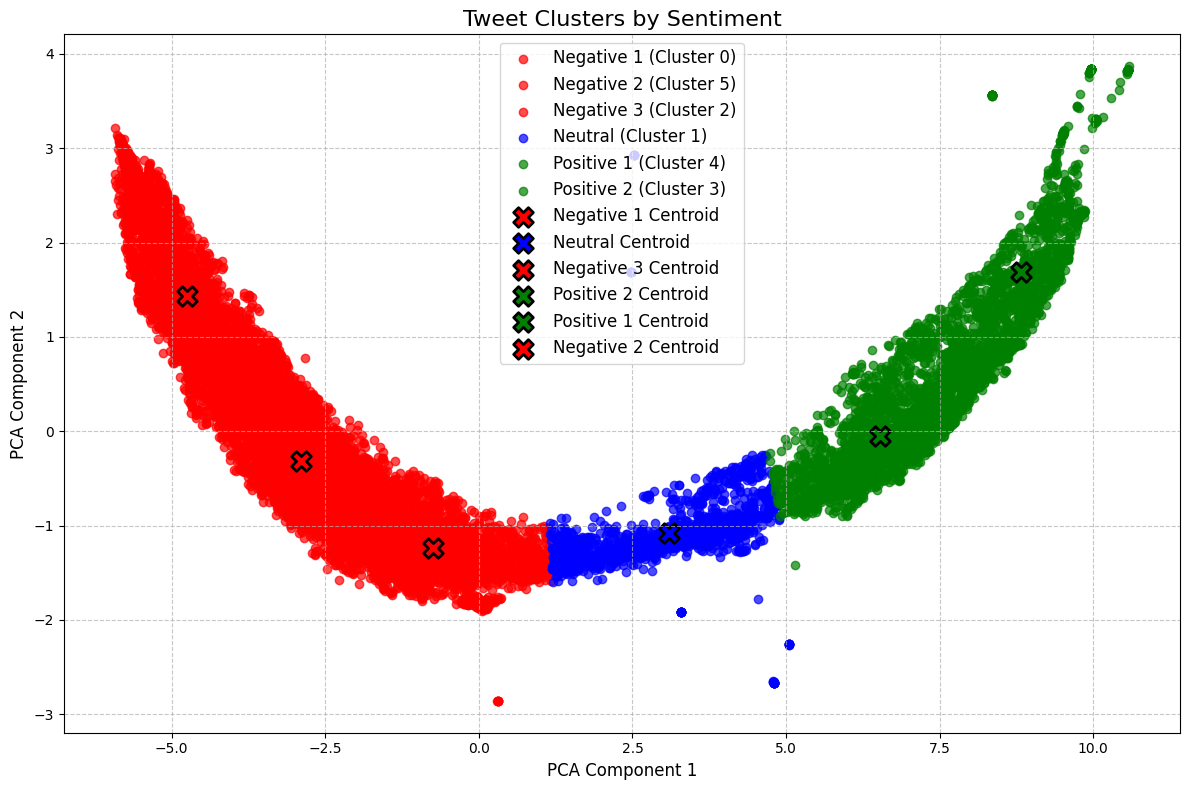


Sentiment Cluster Statistics:
----------------------------------------
Negative 1 Cluster (ID: 0):
  - Size: 3027 tweets (20.7%)
  - Average sentiment score: -1.000
  - Sample tweets:
    1. "@VirginAmerica a lot of "apologies" being thrown out to customers from what I can see.Very sad. Thanks for nothing. Worst airline ever."
    2. "@USAirways is the worst. I have to pay $200 just to NOT take my first flight in a round trip! Otherwise they'll Cancelled Flight my whole flight."
    3. "@united was trying to change a flight online but got an error can you help via DM?"

Negative 2 Cluster (ID: 5):
  - Size: 4002 tweets (27.3%)
  - Average sentiment score: -0.998
  - Sample tweets:
    1. "@AmericanAir that's 16+ extra hours of travel time. Missed vacation time and now you guys are messing with my professional life."
    2. "@united I'm in Denver, my bag is in San Jose. See something wrong here."
    3. "@united @DelonGerry ual sucks"

Negative 3 Cluster (ID: 2):
  - Size: 3086 tweets 

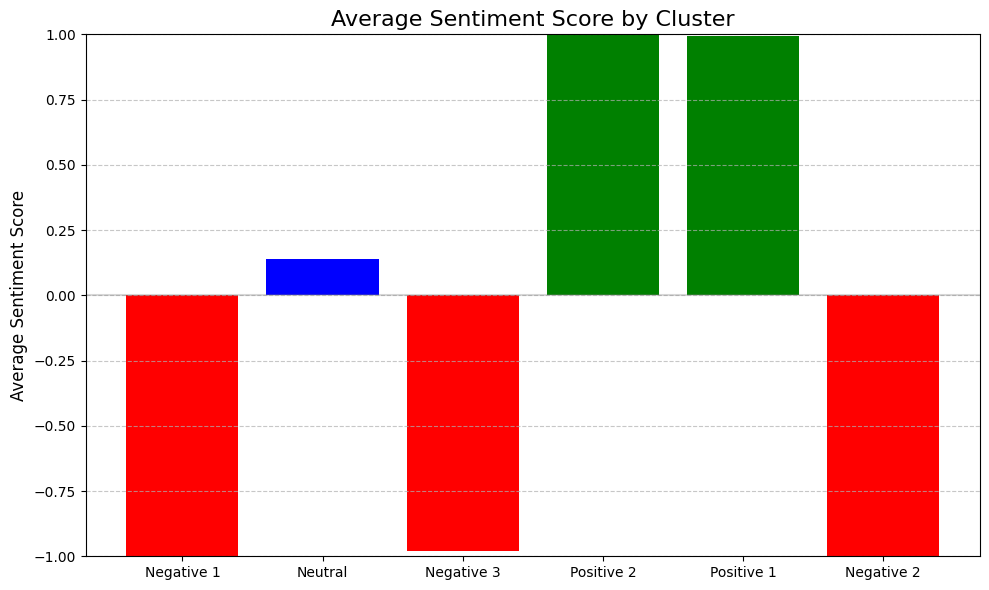

In [ ]:
# Kmeans with 6 clusters

# Apply K-means clustering with 6 clusters
print("Applying K-means clustering...")
n_clusters = 6  # 6 is from Elbow graph
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=100) # initialise centroids using K-means++
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# Add cluster labels to the original dataframe
df['cluster'] = cluster_labels

# Use Hugging Face's sentiment pipeline
print("Running sentiment analysis...")
sentiment_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Get sentiment scores for a sample of tweets from each cluster
cluster_sentiments = {}

for cluster_id in range(n_clusters):
    # Get sample tweets from this cluster
    cluster_df = df[df['cluster'] == cluster_id]

    # Check if there are any tweets in this cluster
    if len(cluster_df) == 0:
        print(f"Warning: Cluster {cluster_id} is empty")
        cluster_sentiments[cluster_id] = 0
        continue

    # Sample tweets for analysis (to avoid processing all of them)
    sample_size = min(100, len(cluster_df))
    sampled_tweets = cluster_df['clean_text_emoji'].sample(sample_size, random_state=100).tolist()

    # Get sentiment for each tweet
    results = sentiment_classifier(sampled_tweets)

    # Calculate average sentiment score
    sentiment_scores = []
    for result in results:
        if result['label'] == 'POSITIVE':
            sentiment_scores.append(result['score'])  # Positive sentiment
        elif result['label'] == 'NEGATIVE':
            sentiment_scores.append(-result['score'])  # Negative sentiment
        else:
            sentiment_scores.append(0)  # Neutral sentiment

    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    cluster_sentiments[cluster_id] = avg_sentiment
    print(f"Cluster {cluster_id}: {len(cluster_df)} tweets, avg sentiment = {avg_sentiment:.3f}")

# Map clusters to sentiment labels (positive, negative, neutral)

sorted_clusters = sorted(cluster_sentiments.items(), key=lambda x: x[1]) # Sort clusters by average sentiment score
sentiment_mapping = {
    sorted_clusters[0][0]: "Negative 1",    # Lowest sentiment score
    sorted_clusters[1][0]: "Negative 2",
    sorted_clusters[2][0]: "Negative 3",
    sorted_clusters[3][0]: "Neutral",
    sorted_clusters[4][0]: "Positive 1",
    sorted_clusters[5][0]: "Positive 2",  # Highest sentiment score
}

print("Sentiment mapping:", sentiment_mapping)

# Add sentiment labels to the dataframe
df['sentiment'] = df['cluster'].map(sentiment_mapping)

# Reduce dimensionality for visualization
print("Reducing dimensionality for visualization...")
pca = PCA(n_components=2)
pca_reduced_embeddings = pca.fit_transform(reduced_embeddings)

# Visualize the clusters with sentiment labels
print("Creating visualization...")
plt.figure(figsize=(12, 8))

# Define colors for each sentiment
colors = {"Positive 1": "green", "Positive 2": "green", "Neutral": "blue", "Negative 1": "red", "Negative 2": "red", "Negative 3": "red"}

for cluster_id, sentiment in sentiment_mapping.items():
    # Get indices where cluster_labels matches cluster_id
    indices = np.where(cluster_labels == cluster_id)[0]

    # Use those indices to select the right points from reduced_embeddings
    cluster_points = pca_reduced_embeddings[indices]

    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f'{sentiment} (Cluster {cluster_id})',
        color=colors[sentiment],
        alpha=0.7
    )

# Add centroids to the plot
centroids = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(centroids):
    sentiment = sentiment_mapping[i]
    plt.scatter(x, y, s=200, marker='X', color=colors[sentiment],
                edgecolor='black', linewidth=2,
                label=f'{sentiment} Centroid')

# Improve the plot appearance
plt.title('Tweet Clusters by Sentiment', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sentiment_clusters.png', dpi=300)
plt.show()

# Print statistics about each sentiment cluster
print("\nSentiment Cluster Statistics:")
print("-" * 40)
for cluster_id, sentiment in sentiment_mapping.items():
    cluster_size = sum(df['cluster'] == cluster_id)
    print(f"{sentiment} Cluster (ID: {cluster_id}):")
    print(f"  - Size: {cluster_size} tweets ({cluster_size/len(df)*100:.1f}%)")
    print(f"  - Average sentiment score: {cluster_sentiments[cluster_id]:.3f}")

    # Only proceed if cluster has tweets
    if cluster_size > 0:
        # Sample tweets from this cluster
        print(f"  - Sample tweets:")
        sample_tweets = df[df['cluster'] == cluster_id]['text'].sample(min(3, cluster_size), random_state=100)
        for i, tweet in enumerate(sample_tweets, 1):
            print(f"    {i}. \"{tweet}\"")
    print()

# Create a bar chart showing average sentiment scores by cluster
plt.figure(figsize=(10, 6))
sentiment_labels = [sentiment_mapping[i] for i in range(n_clusters)]
avg_scores = [cluster_sentiments[i] for i in range(n_clusters)]

# Map sentiments to colors
bar_colors = [colors[label] for label in sentiment_labels]

plt.bar(sentiment_labels, avg_scores, color=bar_colors)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title('Average Sentiment Score by Cluster', fontsize=16)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sentiment_scores.png', dpi=300)
plt.show()


## Evaluating the results
We compared the predicted sentiment labels for each tweet with the actual airline sentiment labels in the dataset. We then calculated the overall clustering accuracy and F1 score for each cluster. Using this, we found the weighted F1 score. The accuracy is given to be 71%, which indicates that the model is neither overfitted nor underfitted. A confusion matrix is also plotted to show how many data points are misclassified in each category. We can see that the neutral tweets have a higher misclassification rate. We also found that many of the misclassified tweets have sentiment confidence value of less than 1, which could be the reason for their misclassification.

Clustering Accuracy: 0.709
Weighted F1 Score: 0.676
Clustering Performance Report:
              precision    recall  f1-score   support

    Negative       0.79      0.87      0.83      9178
     Neutral       0.38      0.15      0.22      3099
    Positive       0.59      0.81      0.68      2362

    accuracy                           0.71     14639
   macro avg       0.58      0.61      0.58     14639
weighted avg       0.67      0.71      0.68     14639



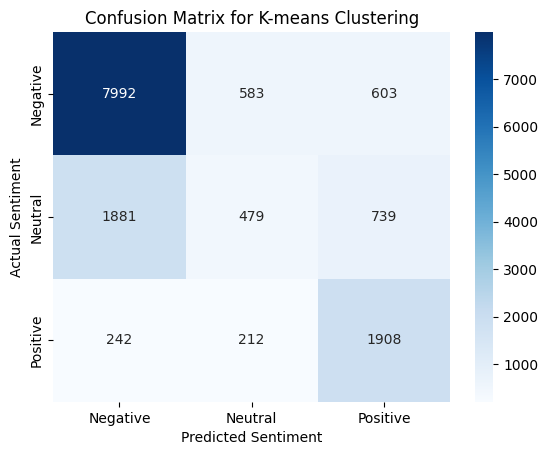

Incorrectly classified tweets:
    airline_sentiment  sentiment_confidence
2             neutral                0.6837
6            positive                0.6745
7             neutral                0.6340
8            positive                0.6559
10            neutral                0.6769
22            neutral                1.0000
26            neutral                0.6854
28            neutral                0.6150
30            neutral                1.0000
36           positive                1.0000
37            neutral                0.6791
42            neutral                0.6578
43            neutral                1.0000
45            neutral                0.6799
46           positive                1.0000
47            neutral                1.0000
48            neutral                0.6436
49            neutral                0.6764
51            neutral                1.0000
52            neutral                0.7118
53            neutral                1.0000
5

In [ ]:
# Comparing my clusters with the actual airline sentiment

# Converting airline_sentiment to numeric labels
df['airline_sentiment_numeric'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Convert cluster sentiments to numberic labels
cluster_to_sentiment = {
    "Negative 1": 0,
    "Negative 2": 0,
    "Negative 3": 0,
    "Neutral": 1,
    "Positive 1": 2,
    "Positive 2": 2,
}

df['cluster_sentiment_numeric'] = df['sentiment'].map(cluster_to_sentiment)

# Compare cluster_sentiment_numeric to airline_sentiment_numeric
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(df['airline_sentiment_numeric'], df['cluster_sentiment_numeric'])
print(f"Clustering Accuracy: {accuracy:.3f}")
weighted_f1 = f1_score(df['airline_sentiment_numeric'], df['cluster_sentiment_numeric'], average='weighted')

print(f"Weighted F1 Score: {weighted_f1:.3f}")

# Detailed performance metrics
from sklearn.metrics import classification_report

print("Clustering Performance Report:")
print(classification_report(df['airline_sentiment_numeric'], df['cluster_sentiment_numeric'], target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['airline_sentiment_numeric'], df['cluster_sentiment_numeric'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")
plt.title("Confusion Matrix for K-means Clustering")
plt.show()

# Filter rows where predictions are incorrect
incorrect_predictions = df[df['airline_sentiment_numeric'] != df['cluster_sentiment_numeric']]

# Checking to see if incorrect classifications are those with low sentiment confidence
# Display mismatched rows
print("Incorrectly classified tweets:")
incorrect = incorrect_predictions[['text', 'airline_sentiment', 'sentiment_confidence', 'sentiment']]
print(incorrect[['airline_sentiment', 'sentiment_confidence']][0:50])


